# lecture 5 Automatic program optimization
在之前的课程中我们了解了如何去构建一个 primitive tensor function 并且将其整合成端到端的模型，下面为涉及到的三个抽象：
- A computational graph view that drives the high-level executions.
- Abstraction for primitive tensor functions.
- Library function calls via environment function registration.

有很多不同的方式来变换相同的程序，这一章将会讨论自动化这一过程，能够较为快速地找到最优的变换。

## 准备
import some package

In [1]:
from __future__ import annotations
import tvm
from tvm.ir.module import IRModule
from tvm.script import tir as T, relax as R
import numpy as np
from tvm import relax
# This is needed for deferring annotation parsing in TVMScript


## Recap: Transform a Primitive Tensor Function.

In [2]:
# matrix multiply
@tvm.script.ir_module
class MyModule:
    @T.prim_func
    def main(
        A: T.Buffer[(128, 128), "float32"],
        B: T.Buffer[(128, 128), "float32"],
        C: T.Buffer[(128, 128), "float32"]
    ):
        T.func_attr({"global_symbol": "main", "tir.noalias": True})
        for i, j, k in T.grid(128, 128, 128):
            with T.block("C"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    C[vi, vj] = T.float32(0.0)
                C[vi, vj] = C[vi, vj] + A[vi, vk] * B[vk, vj]

In [3]:
dtype = "float32"
a_np = np.random.rand(128, 128).astype(dtype)
b_np = np.random.rand(128, 128).astype(dtype)
c_mm = a_np @ b_np

In [4]:
a_nd = tvm.nd.array(a_np)
b_nd = tvm.nd.array(b_np)
c_nd = tvm.nd.array(np.empty((128, 128), dtype="float32"))

lib = tvm.build(MyModule, target="llvm")
f_timer_before = lib.time_evaluator("main", tvm.cpu())
print("Time cost of MyModule: %.3f ms" % (f_timer_before(a_nd, b_nd, c_nd).mean * 1000))

Time cost of MyModule: 2.843 ms


transform MyModule

In [5]:
def schedule_mm(sch: tvm.tir.Schedule, jfactor=4):
    block_C = sch.get_block("C", "main")
    i, j, k = sch.get_loops(block=block_C)
    j_0, j_1 = sch.split(loop=j, factors=[None, jfactor])
    sch.reorder(i, j_0, k, j_1)
    sch.decompose_reduction(block_C, k)
    return sch

In [6]:
sch = tvm.tir.Schedule(MyModule)
sch = schedule_mm(sch)
print(sch.mod.script())

@tvm.script.ir_module
class Module:
    @tir.prim_func
    def main(A: tir.Buffer[(128, 128), "float32"], B: tir.Buffer[(128, 128), "float32"], C: tir.Buffer[(128, 128), "float32"]) -> None:
        # function attr dict
        tir.func_attr({"global_symbol": "main", "tir.noalias": True})
        # body
        # with tir.block("root")
        for i, j_0 in tir.grid(128, 32):
            for j_1_init in tir.serial(4):
                with tir.block("C_init"):
                    vi = tir.axis.spatial(128, i)
                    vj = tir.axis.spatial(128, j_0 * 4 + j_1_init)
                    tir.reads()
                    tir.writes(C[vi, vj])
                    C[vi, vj] = tir.float32(0)
            for k, j_1 in tir.grid(128, 4):
                with tir.block("C_update"):
                    vi = tir.axis.spatial(128, i)
                    vj = tir.axis.spatial(128, j_0 * 4 + j_1)
                    vk = tir.axis.reduce(128, k)
                    tir.reads(C[vi, vj], A[vi, vk

In [7]:
lib = tvm.build(sch.mod, target="llvm")
f_timer_after = lib.time_evaluator("main", tvm.cpu())
print("Time cost of MyModule=>schedule_mm: %.3f ms" % (f_timer_after(a_nd, b_nd, c_nd).mean * 1000))

Time cost of MyModule=>schedule_mm: 1.979 ms


## Transformation Trace

In [8]:
print(sch.trace)

b0 = sch.get_block(name="C", func_name="main")
l1, l2, l3 = sch.get_loops(block=b0)
l4, l5 = sch.split(loop=l2, factors=[None, 4])
sch.reorder(l1, l4, l3, l5)
b6 = sch.decompose_reduction(block=b0, loop=l3)


In [9]:
# 和我们刚才写的 schedule 相同
def schedule_mm(sch: tvm.tir.Schedule, jfactor=4):
    block_C = sch.get_block("C", "main")
    i, j, k = sch.get_loops(block=block_C)
    j_0, j_1 = sch.split(loop=j, factors=[None, jfactor])
    sch.reorder(i, j_0, k, j_1)
    sch.decompose_reduction(block_C, k)
    return sch


## Stochastic schedule transformation
到目前为止，我们已经知道了我们能够根据自己的先验知识设置变换参数对张量程序进行变换，但是在实际应用中，我们不可能手动穷举所有的变换可能，

一个比较实际的想法是在这些可能的变换中设置一些变量

下面的代码通过 `sch.sample_perfect_tile` 来得到随机变量 `jfactor`，每次执行后的 `jfactor` 的值都不相同。

In [10]:
def stochastic_schedule_mm(sch: tvm.tir.Schedule):
    block_C = sch.get_block("C", "main")
    i, j, k = sch.get_loops(block=block_C)
    jfactors = sch.sample_perfect_tile(loop=j, n = 2)
    j_0, j_1 = sch.split(loop=j, factors=jfactors)
    sch.reorder(i, j_0, k, j_1)
    sch.decompose_reduction(block_C, k)
    return sch
sch = tvm.tir.Schedule(MyModule)
print(stochastic_schedule_mm(sch).trace)

b0 = sch.get_block(name="C", func_name="main")
l1, l2, l3 = sch.get_loops(block=b0)
v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[128, 1])
l6, l7 = sch.split(loop=l2, factors=[v4, v5])
sch.reorder(l1, l6, l3, l7)
b8 = sch.decompose_reduction(block=b0, loop=l3)


将 `jfactor` 设置为变量之后我们就得到了一个程序空间，我们可以通过在这个程序空间中进行搜索得到最优化的程序

Elements in the j_factors are not real integer numbers. Instead, they are symbolic variables that refer to a random variable being sampled. We can pass these variables to the transformation API to specify choices such as factor values.

In [11]:
sch = tvm.tir.Schedule(MyModule)
block_C = sch.get_block("C", "main")
i, j, k = sch.get_loops(block=block_C)
j_factors = sch.sample_perfect_tile(loop=j, n=2)
type(j_factors[0])

tvm.tir.expr.Var

In [12]:
print(sch.trace)

b0 = sch.get_block(name="C", func_name="main")
l1, l2, l3 = sch.get_loops(block=b0)
v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[128, 1])


## Search over stochastic transformation
我们已经使用 `stochastic_schedule_mm` 将一个初始的程序变为了一个在功能上等价的，但是有不同的实现的程序空间

那么如何从这个程序空间中得到最好的程序呢？

我们需要一个搜索算法，下面是一种比较直接的搜索算法——随机搜索

In [13]:
def random_search(mod: tvm.ir.IRModule, num_trials: int = 5):
    
    best_result = None
    best_sch = None

    for i in range(num_trials):
        sch = stochastic_schedule_mm(tvm.tir.Schedule(mod))
        lib = tvm.build(sch.mod, target="llvm")
        f_timer_after = lib.time_evaluator("main", tvm.cpu())
        result = f_timer_after(a_nd, b_nd, c_nd).mean

        print("=====Attempt %d, time-cost: %.3f ms====" % (i, result * 1000))
        print(sch.trace)
        if best_result is None or result < best_result:
            best_result = result
            best_sch = sch      
    return best_sch

sch = random_search(MyModule, 5)

=====Attempt 0, time-cost: 2.007 ms====
b0 = sch.get_block(name="C", func_name="main")
l1, l2, l3 = sch.get_loops(block=b0)
v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[32, 4])
l6, l7 = sch.split(loop=l2, factors=[v4, v5])
sch.reorder(l1, l6, l3, l7)
b8 = sch.decompose_reduction(block=b0, loop=l3)
=====Attempt 1, time-cost: 1.522 ms====
b0 = sch.get_block(name="C", func_name="main")
l1, l2, l3 = sch.get_loops(block=b0)
v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[8, 16])
l6, l7 = sch.split(loop=l2, factors=[v4, v5])
sch.reorder(l1, l6, l3, l7)
b8 = sch.decompose_reduction(block=b0, loop=l3)
=====Attempt 2, time-cost: 1.242 ms====
b0 = sch.get_block(name="C", func_name="main")
l1, l2, l3 = sch.get_loops(block=b0)
v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[16, 8])
l6, l7 = sch.split(loop=l2, factors=[v4, v5])
sch.reorder(l1, l6, l3, l7)
b8 = sch.decompose_reduction(block=b0, l

In [14]:
print(sch.trace)

b0 = sch.get_block(name="C", func_name="main")
l1, l2, l3 = sch.get_loops(block=b0)
v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[16, 8])
l6, l7 = sch.split(loop=l2, factors=[v4, v5])
sch.reorder(l1, l6, l3, l7)
b8 = sch.decompose_reduction(block=b0, loop=l3)


在实际中我们使用更加智能的算法帮助我们找到最优程序，我们可以使用 `tvm` 提供的 `meta_schedule`

key idea: use stochastic transformation to specify a search space of good programs, tune_tir API helps to search and find an optimized solution within the search space.

In [21]:
import shutil 

from tvm import meta_schedule as ms
# 记得每次重新运行将文件夹 "./tune_tmp" 删除 
work_dir = "./tune_tmp"
sch_tuned = ms.tune_tir(
    mod = MyModule,
    target = "llvm --num-cores=1",
    config=ms.TuneConfig(
      max_trials_global=64,
      num_trials_per_iter=64,
    ),
    space=ms.space_generator.ScheduleFn(stochastic_schedule_mm),
    work_dir=work_dir,
    task_name="main"
)

shutil.rmtree(work_dir)

2022-07-20 14:20:17.701 INFO Logging directory: ./tune_tmp/logs
2022-07-20 14:20:17.705 INFO Logging directory: ./tune_tmp/logs
2022-07-20 14:20:17.706 INFO Working directory: ./tune_tmp
2022-07-20 14:20:17.707 INFO Creating JSONDatabase. Workload at: ./tune_tmp/database_workload.json. Tuning records at: ./tune_tmp/database_tuning_record.json
2022-07-20 14:20:17.724 INFO LocalBuilder: max_workers = 48
2022-07-20 14:20:18.480 INFO LocalRunner: max_workers = 1
2022-07-20 14:20:19.206 INFO Initializing Task #0: "main"
2022-07-20 14:20:19.368 INFO 
 ID | Name |    FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Terminated 
------------------------------------------------------------------------------------------------------------
  0 | main | 4194304 |      1 |            N/A |          N/A |                   N/A |      0 |            
------------------------------------------------------------------------------------------------------------
Total trials:

查看搜索后的变换的 `trace`

In [22]:
print(sch_tuned.trace)

b0 = sch.get_block(name="C", func_name="main")
l1, l2, l3 = sch.get_loops(block=b0)
v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[8, 16])
l6, l7 = sch.split(loop=l2, factors=[v4, v5])
sch.reorder(l1, l6, l3, l7)
b8 = sch.decompose_reduction(block=b0, loop=l3)
sch.enter_postproc()


看经过搜索后的程序表现

In [23]:
lib = tvm.build(sch_tuned.mod, target="llvm")
time_eval = lib.time_evaluator("main", tvm.cpu())
print("Time cost of MyModule after tuning: %.3f ms" % (time_eval(a_nd, b_nd, c_nd).mean * 1000))

Time cost of MyModule after tuning: 1.530 ms


## Leverage Default AutoScheduling
之前是我们指定了一个变换变量，形成的程序空间，实际上我们可以直接通过 `AutoScheduling` 来对程序进行可能的张量变换的搜索，在 `AutoScheduling` 中会自动寻找那些地方可能会需要搜索从而实现更好的优化，当然我们也可以结合人的先验知识，像上面这个例子一样通过 `space=ms.space_generator.ScheduleFn(stochastic_schedule_mm),` 自己指定一个搜索空间

In [27]:
sch_tuned = ms.tune_tir(
    mod=MyModule,
    target="llvm --num-cores=1",
    config=ms.TuneConfig(
      max_trials_global=64,
      num_trials_per_iter=64,
    ),
    work_dir=work_dir,
    task_name="main",
)
shutil.rmtree(work_dir)

2022-07-20 14:21:39.099 INFO Logging directory: ./tune_tmp/logs
2022-07-20 14:21:39.103 INFO Logging directory: ./tune_tmp/logs
2022-07-20 14:21:39.104 INFO Working directory: ./tune_tmp
2022-07-20 14:21:39.105 INFO Creating JSONDatabase. Workload at: ./tune_tmp/database_workload.json. Tuning records at: ./tune_tmp/database_tuning_record.json
2022-07-20 14:21:39.148 INFO LocalBuilder: max_workers = 48
2022-07-20 14:21:39.833 INFO LocalRunner: max_workers = 1
2022-07-20 14:21:40.483 INFO Initializing Task #0: "main"
2022-07-20 14:21:40.643 INFO 
 ID | Name |    FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Terminated 
------------------------------------------------------------------------------------------------------------
  0 | main | 4194304 |      1 |            N/A |          N/A |                   N/A |      0 |            
------------------------------------------------------------------------------------------------------------
Total trials:

In [30]:
lib = tvm.build(sch_tuned.mod, target="llvm")
time_eval = lib.time_evaluator("main", tvm.cpu())
print("Time cost of MyModule after tuning: %.3f ms" % (time_eval(a_nd, b_nd, c_nd).mean * 1000))

Time cost of MyModule after tuning: 0.066 ms


In [31]:
sch_tuned.trace

b0 = sch.get_block(name="C", func_name="main")
b1 = sch.get_block(name="root", func_name="main")
sch.annotate(block_or_loop=b0, ann_key="meta_schedule.tiling_structure", ann_val="SSRSRS")
l2, l3, l4 = sch.get_loops(block=b0)
v5, v6, v7, v8 = sch.sample_perfect_tile(loop=l2, n=4, max_innermost_factor=64, decision=[4, 4, 1, 8])
l9, l10, l11, l12 = sch.split(loop=l2, factors=[v5, v6, v7, v8])
v13, v14, v15, v16 = sch.sample_perfect_tile(loop=l3, n=4, max_innermost_factor=64, decision=[1, 8, 1, 16])
l17, l18, l19, l20 = sch.split(loop=l3, factors=[v13, v14, v15, v16])
v21, v22 = sch.sample_perfect_tile(loop=l4, n=2, max_innermost_factor=64, decision=[64, 2])
l23, l24 = sch.split(loop=l4, factors=[v21, v22])
sch.reorder(l9, l17, l10, l18, l23, l11, l19, l24, l12, l20)
b25 = sch.cache_write(block=b0, write_buffer_index=0, storage_scope="global")
sch.reverse_compute_at(block=b25, loop=l18, preserve_unit_loops=True)
sch.annotate(block_or_loop=b1, ann_key="meta_schedule.parallel", ann_val=16)
s

In [29]:
print(sch_tuned.mod.script())

@tvm.script.ir_module
class Module:
    @tir.prim_func
    def main(A: tir.Buffer[(128, 128), "float32"], B: tir.Buffer[(128, 128), "float32"], C: tir.Buffer[(128, 128), "float32"]) -> None:
        # function attr dict
        tir.func_attr({"global_symbol": "main", "tir.noalias": True})
        # body
        # with tir.block("root")
        C_global = tir.alloc_buffer([128, 128], dtype="float32")
        for i_0_j_0_i_1_j_1_fused in tir.parallel(128, annotations={"pragma_auto_unroll_max_step":16, "pragma_unroll_explicit":1}):
            for i_2_init, j_2_init, i_3_init in tir.grid(1, 1, 8):
                for j_3_fused_init in tir.vectorized(16):
                    with tir.block("C_init"):
                        vi = tir.axis.spatial(128, (i_0_j_0_i_1_j_1_fused // 32 * 4 + i_0_j_0_i_1_j_1_fused % 32 // 8 + i_2_init) * 8 + i_3_init)
                        vj = tir.axis.spatial(128, (0 * 8 + i_0_j_0_i_1_j_1_fused % 8 + j_2_init) * 16 + j_3_fused_init)
                        tir

让我们对到目前为止所学的内容进行检查。

- 随机调度允许我们表示“可能的变换是什么”。

- Meta-Schedule 的 tune_tir API 帮助我们在搜索空间内找到一个好的解决方案。

- Meta-Schedule 带有一组默认的内置随机变换，涵盖了广泛的搜索空间。

## 回到端到端模型执行
到目前为止，我们已经学会了自动优化单个元张量函数。我们如何才能把利用它改进我们的端到端模型执行？

从 MLC 的角度来看，自动搜索是一个模块化的步骤，我们只需要用调优结果提供的新的元张量函数实现替换原始的元张量函数实现。

我们将重用上一章中的两层 MLP 示例。

In [32]:
import torch
import torchvision

test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

img, label = next(iter(test_loader))
img = img.reshape(1, 28, 28).numpy()

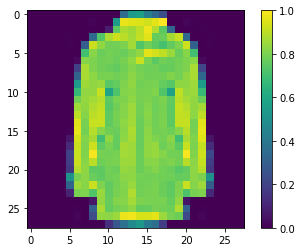

Class: Coat


In [33]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img[0])
plt.colorbar()
plt.grid(False)
plt.show()

print("Class:", class_names[label[0]])

我们同样下载我们将在示例中使用的预训练模型参数。（linear -> relu ->linear）

In [34]:
# Hide outputs
!wget -nc https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl

文件 “fasionmnist_mlp_params.pkl” 已经存在；不获取。



In [35]:
import pickle as pkl

mlp_params = pkl.load(open("fasionmnist_mlp_params.pkl", "rb"))

data_nd = tvm.nd.array(img.reshape(1, 784))
nd_params = {k: tvm.nd.array(v) for k, v in mlp_params.items()}

让我们使用一个混合 IRModule。它其中大多数步骤都调用环境函数，同时带有一个 TensorIR 函数 linear0。

In [36]:
@tvm.script.ir_module
class MyModuleMixture:
    @T.prim_func
    def linear0(X: T.Buffer[(1, 784), "float32"],
                W: T.Buffer[(128, 784), "float32"],
                B: T.Buffer[(128,), "float32"],
                Z: T.Buffer[(1, 128), "float32"]):
        T.func_attr({"global_symbol": "linear0", "tir.noalias": True})
        Y = T.alloc_buffer((1, 128), "float32")
        for i, j, k in T.grid(1, 128, 784):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]

        for i, j in T.grid(1, 128):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] =  Y[vi, vj] + B[vj]

    @R.function
    def main(x: Tensor((1, 784), "float32"),
             w0: Tensor((128, 784), "float32"),
             b0: Tensor((128,), "float32"),
             w1: Tensor((10, 128), "float32"),
             b1: Tensor((10,), "float32")):
        with R.dataflow():
            lv0 = R.call_tir(linear0, (x, w0, b0), (1, 128), dtype="float32")
            lv1 = R.call_tir("env.relu", (lv0,), (1, 128), dtype="float32")
            out = R.call_tir("env.linear", (lv1, w1, b1), (1, 10), dtype="float32")
            R.output(out)
        return out

In [37]:
@tvm.register_func("env.linear", override=True)
def torch_linear(x: tvm.nd.NDArray,
                 w: tvm.nd.NDArray,
                 b: tvm.nd.NDArray,
                 out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    w_torch = torch.from_dlpack(w)
    b_torch = torch.from_dlpack(b)
    out_torch = torch.from_dlpack(out)
    torch.mm(x_torch, w_torch.T, out=out_torch)
    torch.add(out_torch, b_torch, out=out_torch)

@tvm.register_func("env.relu", override=True)
def lnumpy_relu(x: tvm.nd.NDArray,
                out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x   )
    out_torch = torch.from_dlpack(out)
    torch.maximum(x_torch, torch.Tensor([0.0]), out=out_torch)

我们可以绑定参数，看看它是否给出了正确的预测。

In [38]:
MyModuleWithParams = relax.transform.BindParams("main", nd_params)(MyModuleMixture)

In [39]:
ex = relax.vm.build(MyModuleWithParams, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())

nd_res = vm["main"](data_nd)

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModuleWithParams Prediction:", class_names[pred_kind[0]])

MyModuleWithParams Prediction: Coat


In [40]:
ftimer = vm.module.time_evaluator("main", tvm.cpu(), number=100)

print("MyModuleWithParams time-cost: %g ms" % (ftimer(data_nd).mean * 1000))

MyModuleWithParams time-cost: 0.284531 ms


目前，调优 API 只接受一个带有一个 main 函数的 IRModule，所以我们首先将 linear0 取出到另一个模块的 main 函数中并将其传递给 tune_tir。

In [42]:
mod_linear = tvm.IRModule.from_expr(MyModuleMixture["linear0"].with_attr("global_symbol", "main"))
print(mod_linear.script())

@tvm.script.ir_module
class Module:
    @tir.prim_func
    def main(X: tir.Buffer[(1, 784), "float32"], W: tir.Buffer[(128, 784), "float32"], B: tir.Buffer[128, "float32"], Z: tir.Buffer[(1, 128), "float32"]) -> None:
        # function attr dict
        tir.func_attr({"global_symbol": "main", "tir.noalias": True})
        # body
        # with tir.block("root")
        Y = tir.alloc_buffer([1, 128], dtype="float32")
        for i, j, k in tir.grid(1, 128, 784):
            with tir.block("Y"):
                vi, vj, vk = tir.axis.remap("SSR", [i, j, k])
                tir.reads(X[vi, vk], W[vj, vk])
                tir.writes(Y[vi, vj])
                with tir.init():
                    Y[vi, vj] = tir.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]
        for i, j in tir.grid(1, 128):
            with tir.block("Z"):
                vi, vj = tir.axis.remap("SS", [i, j])
                tir.reads(Y[vi, vj], B[vj])
                tir.writes(Z[vi, vj])
   

In [43]:
sch_tuned_linear = ms.tune_tir(
    mod=mod_linear,
    target="llvm --num-cores=1",
    config=ms.TuneConfig(
      max_trials_global=64,
      num_trials_per_iter=64,
    ),
    work_dir=work_dir,
    task_name="main",
)

shutil.rmtree(work_dir)

2022-07-20 14:29:20.415 INFO Logging directory: ./tune_tmp/logs
2022-07-20 14:29:20.419 INFO Logging directory: ./tune_tmp/logs
2022-07-20 14:29:20.420 INFO Working directory: ./tune_tmp
2022-07-20 14:29:20.421 INFO Creating JSONDatabase. Workload at: ./tune_tmp/database_workload.json. Tuning records at: ./tune_tmp/database_tuning_record.json
2022-07-20 14:29:20.422 INFO LocalBuilder: max_workers = 48
2022-07-20 14:29:21.178 INFO LocalRunner: max_workers = 1
2022-07-20 14:29:21.878 INFO Initializing Task #0: "main"
2022-07-20 14:29:22.116 INFO 
 ID | Name |   FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Terminated 
-----------------------------------------------------------------------------------------------------------
  0 | main | 200832 |      1 |            N/A |          N/A |                   N/A |      0 |            
-----------------------------------------------------------------------------------------------------------
Total trials: 0
T

用调优后的新函数替换原来的函数。我们可以通过首先获得一个 global_var（一个指向 IRModule 中函数的 pointer 引用），然后调用 update_func 来用新的函数替换原本的函数。

In [44]:
MyModuleWithParams2 = relax.transform.BindParams("main", nd_params)(MyModuleMixture)
new_func = sch_tuned_linear.mod["main"].with_attr("global_symbol", "linear0")
gv = MyModuleWithParams2.get_global_var("linear0")
MyModuleWithParams2.update_func(gv, new_func)
print(MyModuleWithParams2.script())

@tvm.script.ir_module
class Module:
    @relax.function
    def main(x: Tensor((1, 784), "float32")) -> Tensor(None, "float32", ndim = 2):
        # block 0
        with relax.dataflow():
            lv0 = relax.call_tir(linear0, (x, meta[relay.Constant][0], meta[relay.Constant][1]), (1, 128), dtype="float32")
            lv1 = relax.call_tir("env.relu", (lv0,), (1, 128), dtype="float32")
            out = relax.call_tir("env.linear", (lv1, meta[relay.Constant][2], meta[relay.Constant][3]), (1, 10), dtype="float32")
            relax.output(out)
        return out
    
    @tir.prim_func
    def linear0(X: tir.Buffer[(1, 784), "float32"], W: tir.Buffer[(128, 784), "float32"], B: tir.Buffer[128, "float32"], Z: tir.Buffer[(1, 128), "float32"]) -> None:
        # function attr dict
        tir.func_attr({"global_symbol": "linear0", "tir.noalias": True})
        # body
        # with tir.block("root")
        Y = tir.alloc_buffer([1, 128], dtype="float32")
        for i_0_j_0_i_1_j_1_fused

In [45]:
ex = relax.vm.build(MyModuleWithParams2, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())

nd_res = vm["main"](data_nd)

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModuleWithParams2 Prediction:", class_names[pred_kind[0]])

MyModuleWithParams2 Prediction: Coat


In [46]:
ftimer = vm.module.time_evaluator("main", tvm.cpu(), number=50)

print("MyModuleWithParams2 time-cost: %g ms" % (ftimer(data_nd).mean * 1000))

MyModuleWithParams2 time-cost: 0.224305 ms


## 二维卷积的优化

In [74]:
N, CI, H, W, CO, K = 2, 2, 1024, 1024, 3, 11
OUT_H, OUT_W = H - K + 1, W - K + 1

@tvm.script.ir_module
class MyConv:
    @T.prim_func
    def conv(data: T.Buffer[(N, CI, 1024, 1024), "float32"],
             weight: T.Buffer[(CO, CI, K, K), "float32"],
             res: T.Buffer[(N, CO, OUT_H, OUT_W), "float32"]):
        T.func_attr({"global_symbol": "main", "tir.noalias": True})
        for N_ind, oc_ind, h_ind, w_ind, ci_ind, h_K_ind, w_K_ind in T.grid(N, CO, OUT_H, OUT_W, CI, K, K):
            with T.block("res"):
                v_N_ind, v_oc_ind, v_h_ind, v_w_ind, v_ci_ind, v_h_K_ind, v_w_K_ind = T.axis.remap("SSSSRRR", [N_ind, oc_ind, h_ind, w_ind, ci_ind, h_K_ind, w_K_ind])
                with T.init():
                    res[v_N_ind, v_oc_ind, v_h_ind, v_w_ind] = T.float32(0)
                res[v_N_ind, v_oc_ind, v_h_ind, v_w_ind] = res[v_N_ind, v_oc_ind, v_h_ind, v_w_ind] + data[v_N_ind, v_ci_ind, v_h_K_ind + v_h_ind, v_w_K_ind + v_w_ind] * weight[v_oc_ind, v_ci_ind, v_h_K_ind, v_w_K_ind]


build 查看运行时间

In [75]:
data_np = np.random.randn(N, CI, H, W).astype("float32")
weight_np = np.random.randn(CO, CI, K, K).astype("float32")
res_np = np.empty((N, CO, OUT_H, OUT_W), dtype="float32")

data_nd = tvm.nd.array(data_np)
weight_nd = tvm.nd.array(weight_np)
res_nd = tvm.nd.array(res_np)

lib = tvm.build(MyConv, target="llvm")
time_eval = lib.time_evaluator("main", tvm.cpu())

print("Time cost of MyConv: %.3f ms" % (time_eval(data_nd, weight_nd, res_nd).mean * 1000))
# print(time_eval(data_nd, weight_nd, res_nd))

Time cost of MyConv: 1339.849 ms


In [76]:
sch_tuned = ms.tune_tir(
    mod=MyConv,
    target="llvm --num-cores=1",
    config=ms.TuneConfig(
      max_trials_global=64,
      num_trials_per_iter=64,
    ),
    work_dir=work_dir,
    task_name="main",
)
shutil.rmtree(work_dir)

2022-07-20 14:55:17.581 INFO Logging directory: ./tune_tmp/logs
2022-07-20 14:55:17.586 INFO Logging directory: ./tune_tmp/logs
2022-07-20 14:55:17.587 INFO Working directory: ./tune_tmp
2022-07-20 14:55:17.588 INFO Creating JSONDatabase. Workload at: ./tune_tmp/database_workload.json. Tuning records at: ./tune_tmp/database_tuning_record.json
2022-07-20 14:55:17.590 INFO LocalBuilder: max_workers = 48
2022-07-20 14:55:18.305 INFO LocalRunner: max_workers = 1
2022-07-20 14:55:19.012 INFO Initializing Task #0: "main"
2022-07-20 14:55:19.242 INFO 
 ID | Name |       FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Terminated 
---------------------------------------------------------------------------------------------------------------
  0 | main | 2985881184 |      1 |            N/A |          N/A |                   N/A |      0 |            
---------------------------------------------------------------------------------------------------------------
T

In [77]:
lib = tvm.build(sch_tuned.mod)
time_eval = lib.time_evaluator("main", tvm.cpu())

print("Time cost of optimized MyConv: %.3f ms" % (time_eval(data_nd, weight_nd, res_nd).mean * 1000))

Time cost of optimized MyConv: 20.052 ms


In [78]:
print(sch_tuned.trace)

b0 = sch.get_block(name="res", func_name="main")
b1 = sch.get_block(name="root", func_name="main")
sch.annotate(block_or_loop=b0, ann_key="meta_schedule.tiling_structure", ann_val="SSRSRS")
l2, l3, l4, l5, l6, l7, l8 = sch.get_loops(block=b0)
v9, v10, v11, v12 = sch.sample_perfect_tile(loop=l2, n=4, max_innermost_factor=64, decision=[1, 2, 1, 1])
l13, l14, l15, l16 = sch.split(loop=l2, factors=[v9, v10, v11, v12])
v17, v18, v19, v20 = sch.sample_perfect_tile(loop=l3, n=4, max_innermost_factor=64, decision=[1, 1, 1, 3])
l21, l22, l23, l24 = sch.split(loop=l3, factors=[v17, v18, v19, v20])
v25, v26, v27, v28 = sch.sample_perfect_tile(loop=l4, n=4, max_innermost_factor=64, decision=[338, 1, 3, 1])
l29, l30, l31, l32 = sch.split(loop=l4, factors=[v25, v26, v27, v28])
v33, v34, v35, v36 = sch.sample_perfect_tile(loop=l5, n=4, max_innermost_factor=64, decision=[13, 1, 13, 6])
l37, l38, l39, l40 = sch.split(loop=l5, factors=[v33, v34, v35, v36])
v41, v42 = sch.sample_perfect_tile(loop=l6, n=2

In [73]:
print(sch_tuned.mod.script())

@tvm.script.ir_module
class Module:
    @tir.prim_func
    def main(data: tir.Buffer[(1, 1, 1024, 1024), "float32"], weight: tir.Buffer[(2, 1, 7, 7), "float32"], res: tir.Buffer[(1, 2, 1018, 1018), "float32"]) -> None:
        # function attr dict
        tir.func_attr({"global_symbol": "main", "tir.noalias": True})
        # body
        # with tir.block("root")
        for N_ind_0_oc_ind_0_h_ind_0_fused in tir.parallel(509, annotations={"pragma_auto_unroll_max_step":512, "pragma_unroll_explicit":1}):
            for w_ind_0, N_ind_1, oc_ind_1, h_ind_1, w_ind_1 in tir.grid(1, 1, 2, 1, 1018):
                for N_ind_2_init, oc_ind_2_init, h_ind_2_init, w_ind_2_init, N_ind_3_init, oc_ind_3_init, h_ind_3_init, w_ind_3_init in tir.grid(1, 1, 1, 1, 1, 1, 2, 1):
                    with tir.block("res_init"):
                        v_N_ind = tir.axis.spatial(1, N_ind_3_init + N_ind_2_init + N_ind_1 + 0)
                        v_oc_ind = tir.axis.spatial(2, 0 * 2 + oc_ind_1 + oc_ind_2_in